In [45]:
import albumentations
import json
import numpy as np
import os
import tokenizers
import torch
import wandb

from glob import glob
from pathlib import Path
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    Trainer,
    TrainingArguments
)
from types import SimpleNamespace
from typing import Dict, List, Tuple

import params

In [5]:
# yolos, Conditional DETR & DETA

In [28]:
DATASET_FOLDER = "training_dataset"
TRAIN_DATA = "train_data.json"
VAL_DATA = "val_data.json"
IMAGE_SIZE = 480

In [10]:
def download_data():
    """Download the training & validation datatsets"""

    dataset_artifact = wandb.use_artifact(f'{params.FINAL_DATA_AT}:latest')
    dataset_path = Path(dataset_artifact.download())
    return dataset_path

In [32]:
def process_data(data: dict, data_path: str):
    """Convert data format

    Convert data format from json with multiple keys to a list of [image_info, image annotations]
    :param data: input data
    :type data: json
    :param data_path: path to images
    :type data_path: str
    :return: converted data into a list
    :rtype: [dict, [dict]]
    """

    processed_data = []
    for image_data in tqdm(data["images"]):
        image_path = os.path.join(data_path, image_data["file_name"])
        if not os.path.isfile(image_path):
            continue
        
        height = image_data["height"]
        width = image_data["width"]
        curr_image_id = image_data["id"]
        curr_annos = []
        for anno in data["annotations"]:
            if anno["image_id"] != curr_image_id:
                continue
            
            x, y, w, h = anno["bbox"]
            if w == 0 or h == 0:
                continue
            if x < 0:
                x = 0
            if y < 0:
                y = 0
    
            if x >= width:
                continue
            if x + w > width:
                w = width - x
            
            if y >= height:
                continue
            if y + h > height:
                y = height - y
            
            anno["bbox"] = [x, y, w, h]
            curr_annos.append(anno)

        if len(curr_annos) == 0:
            continue
    
        curr_image_data = image_data.copy()
        curr_image_data["image_path"] = image_path
        processed_data.append((curr_image_data, curr_annos))

    return processed_data

In [33]:
class SeaWorldDataset(Dataset):
    """
    """

    def __init__(self, data: List[Tuple[Dict, List[Dict]]], image_processor, is_augment: str = True):
        self._data = data
        self._image_processor = image_processor

        if is_augment:
            self._transform = albumentations.Compose(
                [
                    albumentations.Affine(
                        scale=(0.75, 95),
                        translate_percent=(10, 30),
                        rotate=(-15, 15),
                        shear=(-15, 15),
                        keep_ratio=True
                    ),
                    albumentations.HorizontalFlip(p=.5),
                    albumentations.RandomBrightnessContrast(p=.5),
                    albumentations.LongestMaxSize(image_processor.size["longest_edge"], always_apply=True),
                ],
                bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
            )
        else:
            self._transform = albumentations.Compose(
                [
                    albumentations.LongestMaxSize(image_processor.size["longest_edge"], always_apply=True),
                ],
                bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
            )

    def __len__(self):
        return len(self._data)

    @staticmethod
    def _format_processed_annotations(bboxes, categories, image_id):
        """
        """

        processed_annotations = []
        for bbox, category_id in zip(bboxes, categories):
            processed_annotations.append(
                {
                    "image_id": image_id,
                    "category_id": category_id,
                    "bbox": [int(arg + 0.5) for arg in bbox],
                    "isCrowd": 0,
                    "area": int(bbox[2] * bbox[3] + 0.5)
                }
            )

        return processed_annotations

    def __getitem__(self, index) -> Tuple[np.ndarray, List[Dict], int]:
        """
        """

        image_data, annotations = self._data[index]
        image_id = image_data["id"]
        bboxes, categories = [], []
        for annotation in annotations:
            bbox = annotation["bbox"]
            category_id = annotation["category_id"]
            bboxes.append(bbox)
            categories.append(category_id)

        image = np.array(Image.open(image_data["image_path"]).convert("RGB"))
        out = self._transform(
            image=image,
            bboxes=bboxes,
            categories=categories
        )
        annotations = self._format_processed_annotations(
            out["bboxes"], out["categories"], image_id
        )

        processed_image = self._image_processor.preprocess(
            images=image, annotations={"image_id": image_id, "annotations": annotations}, return_tensors="pt"
        )
        for key, val in processed_image.items():
            processed_image[key] = val[0]

        return processed_image

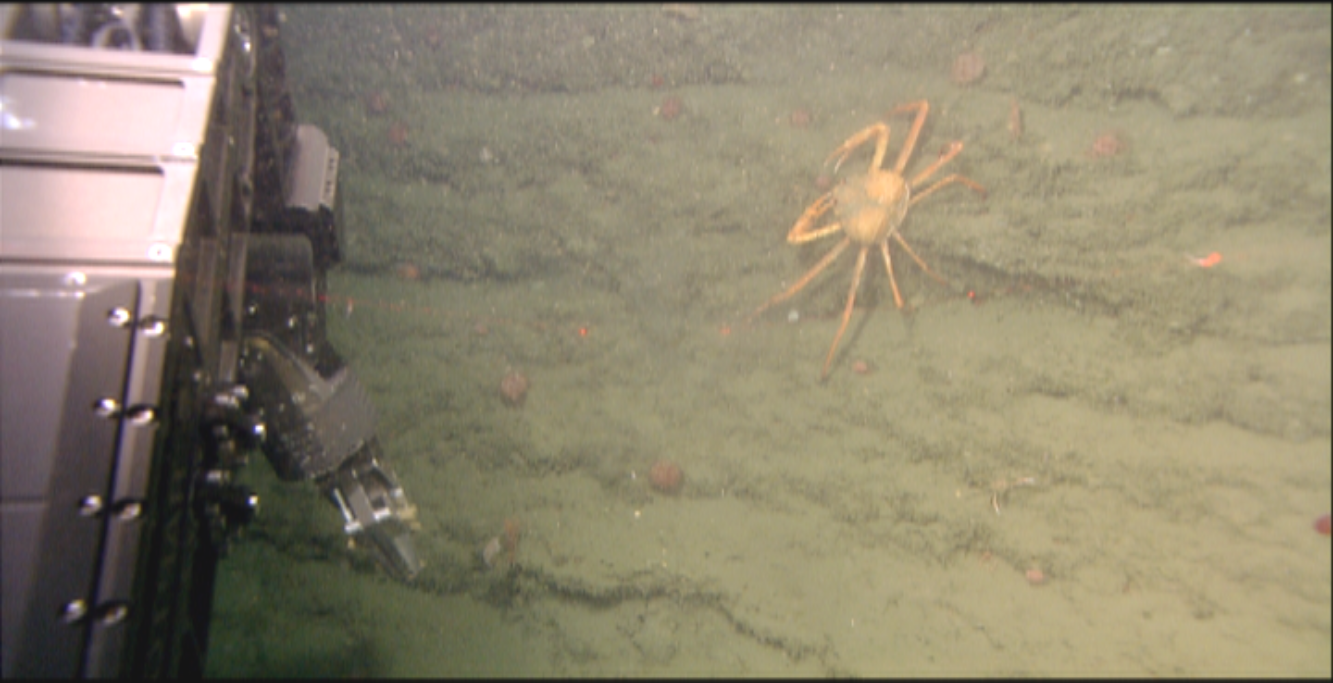

In [139]:
transform = albumentations.Compose(
    [
        albumentations.ShiftScaleRotate(
            shift_limit=(0, 0.3),
            scale_limit=0.2,
            rotate_limit=(-20, 20)
        ),
        albumentations.HorizontalFlip(p=.5),
        albumentations.VerticalFlip(p=.5),
        albumentations.RandomBrightnessContrast(p=.5),
        albumentations.LongestMaxSize(image_processor.size["longest_edge"], always_apply=True),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["categories"]),
)

image_data, annotations = train_dataset._data[155]
bboxes, categories = [], []
for annotation in annotations:
    bbox = annotation["bbox"]
    category_id = annotation["category_id"]
    bboxes.append(bbox)
    categories.append(category_id)

image = np.array(Image.open(image_data["image_path"]).convert("RGB"))
out = transform(
    image=image,
    bboxes=bboxes,
    categories=categories
)
image = Image.fromarray(out["image"])
bboxes = out["bboxes"]
categories = out["categories"]
image

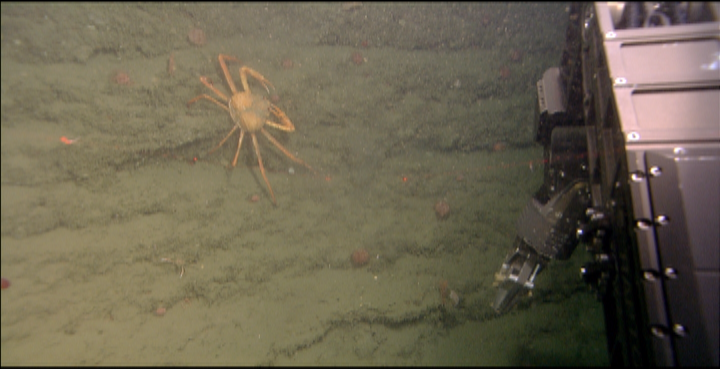

In [80]:
Image.open(image_data["image_path"])

In [ ]:
def collate_fn(batch, is_yolo=False):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    if not is_yolo:
        batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [35]:
def get_training_params(model_name, label2id, id2label, training_mode="bbox_classifier"):
    def create_model(checkpoint):
        return AutoModelForObjectDetection.from_pretrained(
            checkpoint,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
    
    is_yolo = False
    if model_name == "yolos":
        checkpoint = "hustvl/yolos-small"
        is_yolo = True
        model = create_model(checkpoint)
        if training_mode == "bbox_classifier":
            for param in model.vit.parameters():
                param.requires_grad = False
    else:
        if model_name == "DETA":
            checkpoint = "jozhang97/deta-swin-large"
        elif model_name == "CondDETR":
            checkpoint = "microsoft/conditional-detr-resnet-50"

        model = create_model(checkpoint)
        if training_mode == "bbox_classifier":
            for param in model.model.parameters():
                param.requires_grad = False

    image_processor = AutoImageProcessor.from_pretrained(checkpoint)
    return model, image_processor, is_yolo

In [50]:
model_name = "DETA"
training_mode = "bbox_classifier" # "full"
run_name = f"{model_name}_{training_mode}_tuned"

In [11]:
wandb.init(project=params.WANDB_PROJECT, entity=params.ENTITY)
data_path = download_data()

wandb: Downloading large artifact fanthom_final_data:latest, 31335.85MB. 16698 files... 
wandb:   16698 of 16698 files downloaded.  
Done. 0:0:43.6


In [34]:
with open(os.path.join(data_path, DATASET_FOLDER, TRAIN_DATA), "r") as f:
    train_data = json.load(f)
with open(os.path.join(data_path, DATASET_FOLDER, VAL_DATA), "r") as f:
    val_data = json.load(f)
id2label = {cat["id"]: cat["name"] for cat in val_data["categories"]}
label2id = {name: cat_id for cat_id, name in id2label.items()}
val_data = process_data(val_data, "./data/images/")
train_data = process_data(train_data, "./data/images/")

100%|█████████████████████████████████████| 4760/4760 [00:02<00:00, 1680.45it/s]


In [52]:
model, image_processor, is_yolo = get_training_params(model_name, label2id, id2label, training_mode)

Some weights of DetaForObjectDetection were not initialized from the model checkpoint at jozhang97/deta-swin-large and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([133]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([133, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([133]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([133, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([133]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([133, 256]) in the model instantiated
- m

In [56]:
image_processor.size["longest_edge"]

1333

In [37]:
train_dataset = SeaWorldDataset(train_data, image_processor, is_augment=True)
val_dataset = SeaWorldDataset(val_data, image_processor, is_augment=False)

In [42]:
training_args = TrainingArguments(
    output_dir=run_name,
    per_device_train_batch_size=8,
    num_train_epochs=10,
    logging_steps=10,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    load_best_model_at_end=True,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    run_name=run_name
)

In [49]:
os.path.isdir("./artifacts/fanthom_final_data:v0/")

True

In [ ]:
trainer.train()

In [ ]:
wandb.finish()